In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats

In [2]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "3" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')

In [3]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)

br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']
progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [4]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]
    


ep=311
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    
ncluster=8
plotsavenameAdd='_plottingIdx_progBalanced_'+str(i)
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
    clusterRes=pickle.load(output)

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A2 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A3 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA

In [5]:
subclusternumbers=[4,6,8,6,6,6,6,4]
clusterRes_sub=np.zeros(clusterRes.size)-1
for i in np.unique(clusterRes):
    subcluster=subclusternumbers[i]
    subclustersavedir=os.path.join(clustersavedir,savenamecluster+'_subcluster'+str(i))

    savenameclustersub='minibatchkmean_ncluster'+str(subcluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
    with open(os.path.join(subclustersavedir,savenameclustersub), 'rb') as output:
        subclusterRes=pickle.load(output)
        
    clusterRes_sub[clusterRes==i]=subclusterRes

print(np.sum(clusterRes_sub==-1))

0


In [6]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)

In [7]:
#load duct membership and NMCO
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

allstats=None
alllabels=None
alllabels_sub=None
alllatents=None
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]

    path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'duct_nuc_membership',s.split('_')[-1] +'.csv')
    path_s_nmco=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'nmco_features',s.split('_')[-1] +'.csv')
    if not os.path.exists(path_s):
        continue
    print(s)
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]
    assert np.min(plottingIdx_i_s)>=0

    stats_s=pd.read_csv(path_s)
    stats_s.index=stats_s.loc[:,'label']
    stats_s=stats_s.loc[cellIDlist[s][plottingIdx_i_s],'int_median'].to_numpy()
    
    stats_s_nmco=pd.read_csv(path_s_nmco)
    stats_s_nmco.index=stats_s_nmco.loc[:,'label']
    stats_s_nmco=stats_s_nmco.loc[cellIDlist[s][plottingIdx_i_s]].to_numpy()[:,2:-2]

#         ssplit=s.split('_')
    slabels=clusterRes[allImgNames[plottingIdx_i.astype(int)]==s]
    slabels_sub=clusterRes_sub[allImgNames[plottingIdx_i.astype(int)]==s]
    
    if allstats is None:
        allstats=stats_s>0
        alllabels=np.copy(slabels)
        alllabels_sub=np.copy(slabels_sub)
        alllatents=stats_s_nmco
    else:
        allstats=np.concatenate((allstats,stats_s>0),axis=0)
        alllabels=np.concatenate((alllabels,np.copy(slabels)))
        alllabels_sub=np.concatenate((alllabels_sub,np.copy(slabels_sub)))
        alllatents=np.concatenate((alllatents,stats_s_nmco))


br1003a_1_cytokeratin_555_aSMA_647_hoechst_I2
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I7
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
br301_4_cytokeratin_555_aSMA_647_hoechst_A1
br301_4_cytokeratin_555_aSMA_647_hoechst_A2
br301_4_cytokeratin_555_aSMA_647_hoechst_A3
br301_4_cytokeratin_555_aSMA_647_hoechst_A4
br301_4_cytokeratin_555_aSMA_647_hoechst_A5
br301_4_cytokeratin_555_aSMA_647_hoechst_A6
br301_4_cytokeratin_555_aSMA_647_hoechst_B1
br301_4_cytokeratin_555_aSMA_647_hoechst_B2
br301_4_cytokeratin_555_aSMA_647_hoechst_B3
br301_4_cytokeratin_555_aSMA_647_hoechst_B4
br301_4_cytokeratin_555_aSMA_647_hoechst_B5
br301_4_cytokeratin_555_aSMA_647_hoechst_B6
br301_4_cytokeratin_555_aSMA_647_hoechst_C1
br301_4_cytokeratin_555_aSMA_647_hoechst_C2
br301_4_cytokeratin_555_aSMA_647_hoechst_C3
br301_4_cytokeratin_555_aSMA_647_hoechst_C4
br301_4_cytokeratin_555_aSMA_647_hoechst_C5
br301_4_cytokeratin_55

In [8]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=6000
model_str='fc3'

kernel_size=4
stride=2
padding=1

fc_dim1=1024
fc_dim2=1024
fc_dim3=1024


dropout=0.01
kl_weight=0.0000001

name='exp0_ductClf_nmco_subclusters_'+savenamecluster+'fcl3'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)


In [9]:
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainIdx.shape[0]/batchsize))):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        
#         trainInput=trainInputnp[trainIdx]
#         labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(stats_sub[trainIdx_i]).cuda().float()
            labels=torch.tensor(labels_sub[trainIdx_i]).cuda().float()
        optimizer.zero_grad()

        pred = model(trainInput)
#         print(trainInput)
#         print(pred)


        loss=lossCE(pred.flatten(),labels)
        loss_all+=loss.item()
        
        loss.backward()
        optimizer.step()

    loss_all=loss_all/int(np.ceil(trainIdx.shape[0]/batchsize))
    
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            if use_cuda:
                valInput=torch.tensor(stats_sub[valIdx_i]).cuda().float()
                labels=torch.tensor(labels_sub[valIdx_i]).cuda().float()
                
            pred= model(valInput)

            loss_val=lossCE(pred.flatten(),labels).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    if epoch%50==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all

In [10]:
allstats=allstats.astype(int)

In [11]:
alllatents=alllatents.astype(float)
alllatents=scipy.stats.zscore(alllatents,axis=0,nan_policy='omit')
alllatents=np.nan_to_num(alllatents,nan=0)

Epoch: 0000 loss_train: 0.6897 loss_val: 0.6220
Epoch: 0050 loss_train: 0.2938 loss_val: 0.6830
Epoch: 0100 loss_train: 0.0624 loss_val: 1.5550
Epoch: 0150 loss_train: 0.0509 loss_val: 1.5920
Epoch: 0200 loss_train: 0.0203 loss_val: 1.9767
Epoch: 0250 loss_train: 0.0261 loss_val: 2.3795
Epoch: 0300 loss_train: 0.0271 loss_val: 1.8149
Epoch: 0350 loss_train: 0.0086 loss_val: 2.1839
Epoch: 0400 loss_train: 0.0216 loss_val: 2.0410
Epoch: 0450 loss_train: 0.0071 loss_val: 2.0957
Epoch: 0500 loss_train: 0.0171 loss_val: 2.2447
Epoch: 0550 loss_train: 0.0079 loss_val: 2.1687
Epoch: 0600 loss_train: 0.0046 loss_val: 2.2974
Epoch: 0650 loss_train: 0.0192 loss_val: 2.2945
Epoch: 0700 loss_train: 0.0091 loss_val: 2.4793
Epoch: 0750 loss_train: 0.0108 loss_val: 2.2494
Epoch: 0800 loss_train: 0.0114 loss_val: 2.4131
Epoch: 0850 loss_train: 0.0023 loss_val: 2.3379
Epoch: 0900 loss_train: 0.0059 loss_val: 2.7522
Epoch: 0950 loss_train: 0.0063 loss_val: 2.3836
Epoch: 1000 loss_train: 0.0108 loss_val:

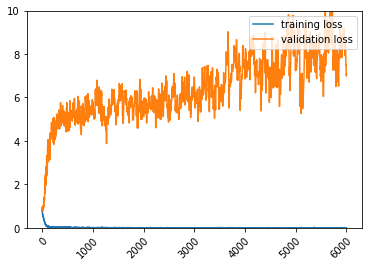

Epoch: 0000 loss_train: 0.6905 loss_val: 0.6811
Epoch: 0050 loss_train: 0.2964 loss_val: 0.7284
Epoch: 0100 loss_train: 0.0967 loss_val: 1.5198
Epoch: 0150 loss_train: 0.0542 loss_val: 1.7068
Epoch: 0200 loss_train: 0.0208 loss_val: 2.0517
Epoch: 0250 loss_train: 0.0307 loss_val: 2.1394
Epoch: 0300 loss_train: 0.0199 loss_val: 2.0023
Epoch: 0350 loss_train: 0.0143 loss_val: 1.9470
Epoch: 0400 loss_train: 0.0191 loss_val: 2.1730
Epoch: 0450 loss_train: 0.0210 loss_val: 2.0857
Epoch: 0500 loss_train: 0.0126 loss_val: 2.1166
Epoch: 0550 loss_train: 0.0148 loss_val: 2.1452
Epoch: 0600 loss_train: 0.0077 loss_val: 2.3761
Epoch: 0650 loss_train: 0.0096 loss_val: 2.2142
Epoch: 0700 loss_train: 0.0060 loss_val: 2.3193
Epoch: 0750 loss_train: 0.0067 loss_val: 2.4403
Epoch: 0800 loss_train: 0.0066 loss_val: 2.5326
Epoch: 0850 loss_train: 0.0099 loss_val: 2.2012
Epoch: 0900 loss_train: 0.0086 loss_val: 2.1820
Epoch: 0950 loss_train: 0.0087 loss_val: 2.4322
Epoch: 1000 loss_train: 0.0083 loss_val:

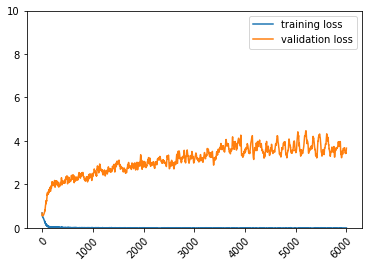

Epoch: 0000 loss_train: 1.0662 loss_val: 0.9734
Epoch: 0050 loss_train: 0.6365 loss_val: 1.0211
Epoch: 0100 loss_train: 0.3140 loss_val: 2.1033
Epoch: 0150 loss_train: 0.1502 loss_val: 3.5170
Epoch: 0200 loss_train: 0.1139 loss_val: 3.5371
Epoch: 0250 loss_train: 0.0621 loss_val: 3.5958
Epoch: 0300 loss_train: 0.0590 loss_val: 4.3314
Epoch: 0350 loss_train: 0.0531 loss_val: 4.4800
Epoch: 0400 loss_train: 0.0455 loss_val: 4.2001
Epoch: 0450 loss_train: 0.0426 loss_val: 4.8949
Epoch: 0500 loss_train: 0.0572 loss_val: 4.3290
Epoch: 0550 loss_train: 0.0509 loss_val: 4.6960
Epoch: 0600 loss_train: 0.0633 loss_val: 4.2778
Epoch: 0650 loss_train: 0.0402 loss_val: 4.1622
Epoch: 0700 loss_train: 0.0349 loss_val: 4.4468
Epoch: 0750 loss_train: 0.0236 loss_val: 5.0088
Epoch: 0800 loss_train: 0.0352 loss_val: 5.0051
Epoch: 0850 loss_train: 0.0298 loss_val: 4.3912
Epoch: 0900 loss_train: 0.0214 loss_val: 5.2345
Epoch: 0950 loss_train: 0.0222 loss_val: 4.9551
Epoch: 1000 loss_train: 0.0233 loss_val:

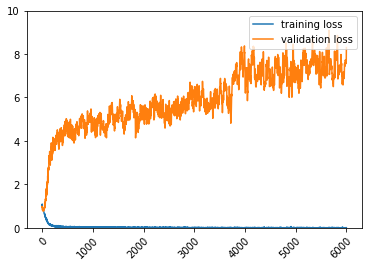

Epoch: 0000 loss_train: 1.1513 loss_val: 1.1188
Epoch: 0050 loss_train: 0.6850 loss_val: 1.1955
Epoch: 0100 loss_train: 0.3421 loss_val: 2.5552
Epoch: 0150 loss_train: 0.1596 loss_val: 4.5289
Epoch: 0200 loss_train: 0.0940 loss_val: 5.1750
Epoch: 0250 loss_train: 0.0999 loss_val: 5.9357
Epoch: 0300 loss_train: 0.0753 loss_val: 5.5907
Epoch: 0350 loss_train: 0.1252 loss_val: 5.1773
Epoch: 0400 loss_train: 0.0535 loss_val: 4.9515
Epoch: 0450 loss_train: 0.0611 loss_val: 5.9113
Epoch: 0500 loss_train: 0.0610 loss_val: 5.8518
Epoch: 0550 loss_train: 0.0747 loss_val: 5.5936
Epoch: 0600 loss_train: 0.0747 loss_val: 5.6893
Epoch: 0650 loss_train: 0.0644 loss_val: 5.4484
Epoch: 0700 loss_train: 0.0412 loss_val: 6.3573
Epoch: 0750 loss_train: 0.0323 loss_val: 5.5120
Epoch: 0800 loss_train: 0.0567 loss_val: 6.6776
Epoch: 0850 loss_train: 0.0373 loss_val: 6.8949
Epoch: 0900 loss_train: 0.0593 loss_val: 7.9477
Epoch: 0950 loss_train: 0.0536 loss_val: 6.4267
Epoch: 1000 loss_train: 0.0411 loss_val:

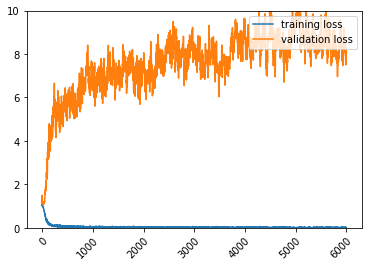

Epoch: 0000 loss_train: 1.1160 loss_val: 1.1445
Epoch: 0050 loss_train: 0.7333 loss_val: 1.5210
Epoch: 0100 loss_train: 0.3386 loss_val: 3.2410
Epoch: 0150 loss_train: 0.1776 loss_val: 4.4827
Epoch: 0200 loss_train: 0.1273 loss_val: 4.9391
Epoch: 0250 loss_train: 0.1018 loss_val: 5.5211
Epoch: 0300 loss_train: 0.0794 loss_val: 5.3295
Epoch: 0350 loss_train: 0.0735 loss_val: 5.8685
Epoch: 0400 loss_train: 0.0818 loss_val: 7.5636
Epoch: 0450 loss_train: 0.0738 loss_val: 6.0311
Epoch: 0500 loss_train: 0.0553 loss_val: 6.7956
Epoch: 0550 loss_train: 0.0431 loss_val: 7.3691
Epoch: 0600 loss_train: 0.0545 loss_val: 6.4591
Epoch: 0650 loss_train: 0.0501 loss_val: 6.9553
Epoch: 0700 loss_train: 0.0498 loss_val: 6.1967
Epoch: 0750 loss_train: 0.0555 loss_val: 7.4001
Epoch: 0800 loss_train: 0.0440 loss_val: 7.8655
Epoch: 0850 loss_train: 0.0390 loss_val: 8.4272
Epoch: 0900 loss_train: 0.0550 loss_val: 6.6803
Epoch: 0950 loss_train: 0.0380 loss_val: 6.6821
Epoch: 1000 loss_train: 0.0325 loss_val:

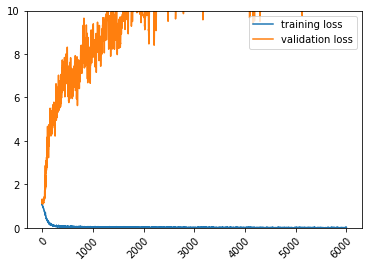

Epoch: 0000 loss_train: 1.1318 loss_val: 0.9865
Epoch: 0050 loss_train: 0.5875 loss_val: 1.2227
Epoch: 0100 loss_train: 0.2107 loss_val: 3.0767
Epoch: 0150 loss_train: 0.1468 loss_val: 2.8555
Epoch: 0200 loss_train: 0.0625 loss_val: 3.4935
Epoch: 0250 loss_train: 0.0677 loss_val: 3.7805
Epoch: 0300 loss_train: 0.0464 loss_val: 3.9946
Epoch: 0350 loss_train: 0.0691 loss_val: 3.5717
Epoch: 0400 loss_train: 0.0494 loss_val: 4.1738
Epoch: 0450 loss_train: 0.0256 loss_val: 4.8997
Epoch: 0500 loss_train: 0.0273 loss_val: 4.7203
Epoch: 0550 loss_train: 0.0408 loss_val: 3.6289
Epoch: 0600 loss_train: 0.0739 loss_val: 4.0590
Epoch: 0650 loss_train: 0.0345 loss_val: 5.1003
Epoch: 0700 loss_train: 0.0315 loss_val: 4.4700
Epoch: 0750 loss_train: 0.0484 loss_val: 4.3006
Epoch: 0800 loss_train: 0.0217 loss_val: 4.5692
Epoch: 0850 loss_train: 0.0294 loss_val: 4.4806
Epoch: 0900 loss_train: 0.0254 loss_val: 4.2006
Epoch: 0950 loss_train: 0.0322 loss_val: 5.1515
Epoch: 1000 loss_train: 0.0404 loss_val:

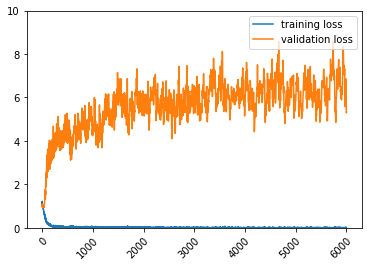

Epoch: 0000 loss_train: 1.1246 loss_val: 1.2595
Epoch: 0050 loss_train: 0.6215 loss_val: 1.2564
Epoch: 0100 loss_train: 0.2984 loss_val: 3.0999
Epoch: 0150 loss_train: 0.1330 loss_val: 4.3380
Epoch: 0200 loss_train: 0.0862 loss_val: 5.2484
Epoch: 0250 loss_train: 0.0463 loss_val: 6.0632
Epoch: 0300 loss_train: 0.0884 loss_val: 6.8909
Epoch: 0350 loss_train: 0.0391 loss_val: 7.1098
Epoch: 0400 loss_train: 0.0515 loss_val: 7.2212
Epoch: 0450 loss_train: 0.0175 loss_val: 7.3432
Epoch: 0500 loss_train: 0.0250 loss_val: 7.6742
Epoch: 0550 loss_train: 0.0471 loss_val: 7.5533
Epoch: 0600 loss_train: 0.0114 loss_val: 8.1718
Epoch: 0650 loss_train: 0.0202 loss_val: 7.9317
Epoch: 0700 loss_train: 0.0113 loss_val: 8.4653
Epoch: 0750 loss_train: 0.0309 loss_val: 7.2556
Epoch: 0800 loss_train: 0.0187 loss_val: 8.4389
Epoch: 0850 loss_train: 0.0072 loss_val: 8.9377
Epoch: 0900 loss_train: 0.0104 loss_val: 8.1893
Epoch: 0950 loss_train: 0.0189 loss_val: 8.5584
Epoch: 1000 loss_train: 0.0554 loss_val:

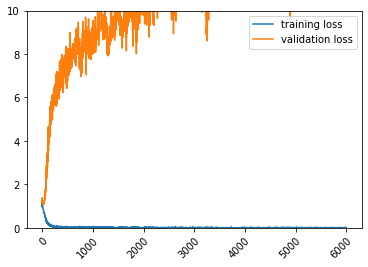

Epoch: 0000 loss_train: 1.0865 loss_val: 1.0291
Epoch: 0050 loss_train: 0.5624 loss_val: 1.3127
Epoch: 0100 loss_train: 0.2015 loss_val: 3.0025
Epoch: 0150 loss_train: 0.0972 loss_val: 6.1278
Epoch: 0200 loss_train: 0.0809 loss_val: 6.3945
Epoch: 0250 loss_train: 0.0575 loss_val: 5.7438
Epoch: 0300 loss_train: 0.0513 loss_val: 7.3413
Epoch: 0350 loss_train: 0.0653 loss_val: 7.3657
Epoch: 0400 loss_train: 0.0421 loss_val: 6.7804
Epoch: 0450 loss_train: 0.0300 loss_val: 7.4987
Epoch: 0500 loss_train: 0.0533 loss_val: 7.0095
Epoch: 0550 loss_train: 0.0180 loss_val: 6.2585
Epoch: 0600 loss_train: 0.0361 loss_val: 6.7719
Epoch: 0650 loss_train: 0.0411 loss_val: 6.6219
Epoch: 0700 loss_train: 0.0390 loss_val: 7.3825
Epoch: 0750 loss_train: 0.0256 loss_val: 7.6327
Epoch: 0800 loss_train: 0.0126 loss_val: 6.9714
Epoch: 0850 loss_train: 0.0246 loss_val: 8.3530
Epoch: 0900 loss_train: 0.0101 loss_val: 7.5533
Epoch: 0950 loss_train: 0.0403 loss_val: 9.1487
Epoch: 1000 loss_train: 0.0106 loss_val:

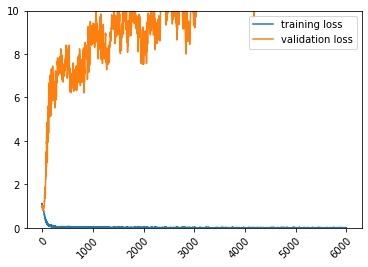

Epoch: 0000 loss_train: 0.6886 loss_val: 0.6769
Epoch: 0050 loss_train: 0.2580 loss_val: 0.7755
Epoch: 0100 loss_train: 0.0715 loss_val: 2.1873
Epoch: 0150 loss_train: 0.0208 loss_val: 2.0979
Epoch: 0200 loss_train: 0.0207 loss_val: 2.3421
Epoch: 0250 loss_train: 0.0114 loss_val: 2.2700
Epoch: 0300 loss_train: 0.0084 loss_val: 2.2461
Epoch: 0350 loss_train: 0.0176 loss_val: 3.1249
Epoch: 0400 loss_train: 0.0105 loss_val: 3.2342
Epoch: 0450 loss_train: 0.0111 loss_val: 3.4955
Epoch: 0500 loss_train: 0.0096 loss_val: 2.9198
Epoch: 0550 loss_train: 0.0040 loss_val: 3.3259
Epoch: 0600 loss_train: 0.0076 loss_val: 3.2456
Epoch: 0650 loss_train: 0.0103 loss_val: 3.3818
Epoch: 0700 loss_train: 0.0129 loss_val: 3.0540
Epoch: 0750 loss_train: 0.0060 loss_val: 2.5330
Epoch: 0800 loss_train: 0.0058 loss_val: 2.3265
Epoch: 0850 loss_train: 0.0077 loss_val: 2.5873
Epoch: 0900 loss_train: 0.0035 loss_val: 2.2409
Epoch: 0950 loss_train: 0.0035 loss_val: 2.6163
Epoch: 1000 loss_train: 0.0041 loss_val:

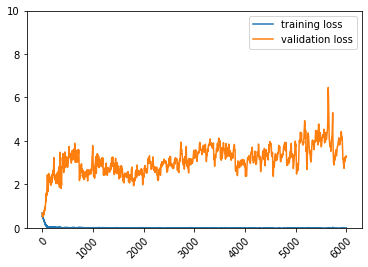

Epoch: 0000 loss_train: 1.0219 loss_val: 1.0967
Epoch: 0050 loss_train: 0.2487 loss_val: 3.0857
Epoch: 0100 loss_train: 0.0683 loss_val: 5.0054
Epoch: 0150 loss_train: 0.0323 loss_val: 6.1270
Epoch: 0200 loss_train: 0.0193 loss_val: 7.0222
Epoch: 0250 loss_train: 0.0122 loss_val: 7.2043
Epoch: 0300 loss_train: 0.0249 loss_val: 7.2696
Epoch: 0350 loss_train: 0.0380 loss_val: 7.9147
Epoch: 0400 loss_train: 0.0166 loss_val: 8.0749
Epoch: 0450 loss_train: 0.0156 loss_val: 6.4842
Epoch: 0500 loss_train: 0.0134 loss_val: 7.7507
Epoch: 0550 loss_train: 0.0079 loss_val: 7.1663
Epoch: 0600 loss_train: 0.0051 loss_val: 8.5421
Epoch: 0650 loss_train: 0.0065 loss_val: 8.4145
Epoch: 0700 loss_train: 0.0068 loss_val: 8.4011
Epoch: 0750 loss_train: 0.0060 loss_val: 7.9050
Epoch: 0800 loss_train: 0.0132 loss_val: 9.0583
Epoch: 0850 loss_train: 0.0090 loss_val: 8.5053
Epoch: 0900 loss_train: 0.0132 loss_val: 7.9946
Epoch: 0950 loss_train: 0.0016 loss_val: 7.8688
Epoch: 1000 loss_train: 0.0179 loss_val:

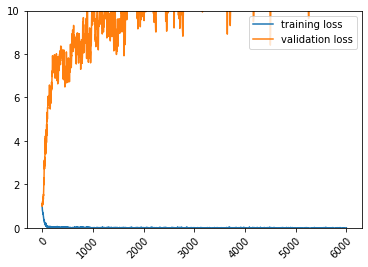

Epoch: 0000 loss_train: 0.7053 loss_val: 0.6865
Epoch: 0050 loss_train: 0.1772 loss_val: 0.5203
Epoch: 0100 loss_train: 0.0500 loss_val: 0.7161
Epoch: 0150 loss_train: 0.0226 loss_val: 0.9504
Epoch: 0200 loss_train: 0.0231 loss_val: 0.9618
Epoch: 0250 loss_train: 0.0117 loss_val: 1.1488
Epoch: 0300 loss_train: 0.0095 loss_val: 1.3069
Epoch: 0350 loss_train: 0.0082 loss_val: 1.3383
Epoch: 0400 loss_train: 0.0075 loss_val: 1.4020
Epoch: 0450 loss_train: 0.0022 loss_val: 1.5021
Epoch: 0500 loss_train: 0.0044 loss_val: 1.1034
Epoch: 0550 loss_train: 0.0089 loss_val: 1.4644
Epoch: 0600 loss_train: 0.0018 loss_val: 1.6757
Epoch: 0650 loss_train: 0.0010 loss_val: 1.4870
Epoch: 0700 loss_train: 0.0013 loss_val: 1.2319
Epoch: 0750 loss_train: 0.0030 loss_val: 1.3518
Epoch: 0800 loss_train: 0.0022 loss_val: 1.0833
Epoch: 0850 loss_train: 0.0030 loss_val: 1.5308
Epoch: 0900 loss_train: 0.0027 loss_val: 1.3147
Epoch: 0950 loss_train: 0.0004 loss_val: 1.8648
Epoch: 1000 loss_train: 0.0019 loss_val:

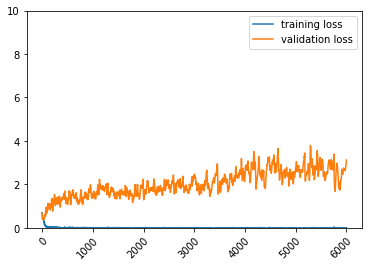

Epoch: 0000 loss_train: 0.8230 loss_val: 0.8647
Epoch: 0050 loss_train: 0.3559 loss_val: 0.8112
Epoch: 0100 loss_train: 0.1102 loss_val: 1.6084
Epoch: 0150 loss_train: 0.0525 loss_val: 1.9088
Epoch: 0200 loss_train: 0.0278 loss_val: 2.3607
Epoch: 0250 loss_train: 0.0199 loss_val: 2.4203
Epoch: 0300 loss_train: 0.0133 loss_val: 2.2153
Epoch: 0350 loss_train: 0.0188 loss_val: 2.4060
Epoch: 0400 loss_train: 0.0194 loss_val: 2.3581
Epoch: 0450 loss_train: 0.0069 loss_val: 2.1679
Epoch: 0500 loss_train: 0.0140 loss_val: 2.5656
Epoch: 0550 loss_train: 0.0051 loss_val: 2.4265
Epoch: 0600 loss_train: 0.0242 loss_val: 2.2982
Epoch: 0650 loss_train: 0.0114 loss_val: 2.4851
Epoch: 0700 loss_train: 0.0094 loss_val: 2.7245
Epoch: 0750 loss_train: 0.0080 loss_val: 2.2260
Epoch: 0800 loss_train: 0.0048 loss_val: 2.5235
Epoch: 0850 loss_train: 0.0094 loss_val: 2.4452
Epoch: 0900 loss_train: 0.0063 loss_val: 2.6983
Epoch: 0950 loss_train: 0.0102 loss_val: 2.4633
Epoch: 1000 loss_train: 0.0119 loss_val:

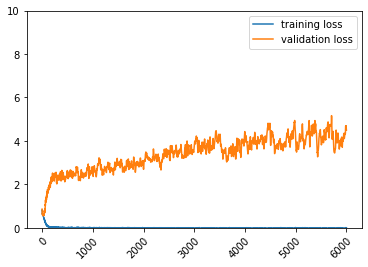

Epoch: 0000 loss_train: 0.6841 loss_val: 0.6713
Epoch: 0050 loss_train: 0.1911 loss_val: 1.0245
Epoch: 0100 loss_train: 0.0514 loss_val: 2.1617
Epoch: 0150 loss_train: 0.0218 loss_val: 2.3642
Epoch: 0200 loss_train: 0.0206 loss_val: 2.5868
Epoch: 0250 loss_train: 0.0087 loss_val: 2.8179
Epoch: 0300 loss_train: 0.0088 loss_val: 2.6502
Epoch: 0350 loss_train: 0.0054 loss_val: 2.8596
Epoch: 0400 loss_train: 0.0065 loss_val: 3.0112
Epoch: 0450 loss_train: 0.0105 loss_val: 3.0976
Epoch: 0500 loss_train: 0.0221 loss_val: 2.9415
Epoch: 0550 loss_train: 0.0068 loss_val: 2.9616
Epoch: 0600 loss_train: 0.0093 loss_val: 3.1293
Epoch: 0650 loss_train: 0.0072 loss_val: 2.8214
Epoch: 0700 loss_train: 0.0064 loss_val: 2.7410
Epoch: 0750 loss_train: 0.0113 loss_val: 2.7790
Epoch: 0800 loss_train: 0.0024 loss_val: 3.3408
Epoch: 0850 loss_train: 0.0091 loss_val: 3.1120
Epoch: 0900 loss_train: 0.0093 loss_val: 3.1269
Epoch: 0950 loss_train: 0.0056 loss_val: 3.4163
Epoch: 1000 loss_train: 0.0123 loss_val:

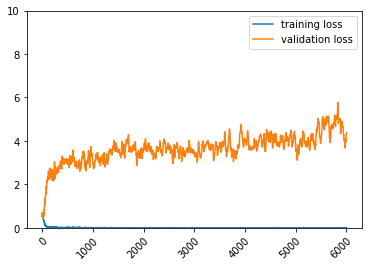

Epoch: 0000 loss_train: 0.9500 loss_val: 0.9117
Epoch: 0050 loss_train: 0.1980 loss_val: 1.0872
Epoch: 0100 loss_train: 0.0220 loss_val: 2.6369
Epoch: 0150 loss_train: 0.0149 loss_val: 2.6314
Epoch: 0200 loss_train: 0.0186 loss_val: 3.5577
Epoch: 0250 loss_train: 0.0126 loss_val: 3.5812
Epoch: 0300 loss_train: 0.0251 loss_val: 3.4986
Epoch: 0350 loss_train: 0.0029 loss_val: 3.9017
Epoch: 0400 loss_train: 0.0122 loss_val: 4.3567
Epoch: 0450 loss_train: 0.0079 loss_val: 3.5399
Epoch: 0500 loss_train: 0.0046 loss_val: 4.2666
Epoch: 0550 loss_train: 0.0031 loss_val: 4.0996
Epoch: 0600 loss_train: 0.0228 loss_val: 4.1036
Epoch: 0650 loss_train: 0.0070 loss_val: 4.0313
Epoch: 0700 loss_train: 0.0086 loss_val: 4.3319
Epoch: 0750 loss_train: 0.0010 loss_val: 4.5587
Epoch: 0800 loss_train: 0.0143 loss_val: 4.5433
Epoch: 0850 loss_train: 0.0035 loss_val: 4.8804
Epoch: 0900 loss_train: 0.0203 loss_val: 4.3978
Epoch: 0950 loss_train: 0.0107 loss_val: 4.9745
Epoch: 1000 loss_train: 0.0024 loss_val:

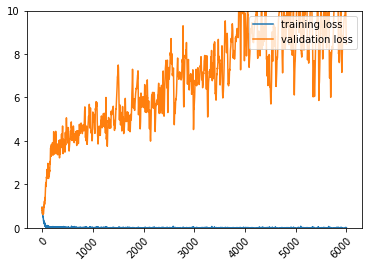

Epoch: 0000 loss_train: 0.8665 loss_val: 0.8295
Epoch: 0050 loss_train: 0.2934 loss_val: 1.7415
Epoch: 0100 loss_train: 0.1246 loss_val: 3.3028
Epoch: 0150 loss_train: 0.0360 loss_val: 4.3506
Epoch: 0200 loss_train: 0.0391 loss_val: 4.6100
Epoch: 0250 loss_train: 0.0096 loss_val: 5.8990
Epoch: 0300 loss_train: 0.0123 loss_val: 5.3040
Epoch: 0350 loss_train: 0.0319 loss_val: 4.8355
Epoch: 0400 loss_train: 0.0217 loss_val: 5.3126
Epoch: 0450 loss_train: 0.0163 loss_val: 5.4677
Epoch: 0500 loss_train: 0.0104 loss_val: 5.5829
Epoch: 0550 loss_train: 0.0196 loss_val: 5.4939
Epoch: 0600 loss_train: 0.0175 loss_val: 5.7005
Epoch: 0650 loss_train: 0.0027 loss_val: 5.9575
Epoch: 0700 loss_train: 0.0139 loss_val: 5.6327
Epoch: 0750 loss_train: 0.0023 loss_val: 5.4976
Epoch: 0800 loss_train: 0.0072 loss_val: 6.4045
Epoch: 0850 loss_train: 0.0109 loss_val: 6.5529
Epoch: 0900 loss_train: 0.0065 loss_val: 6.0920
Epoch: 0950 loss_train: 0.0134 loss_val: 5.4730
Epoch: 1000 loss_train: 0.0049 loss_val:

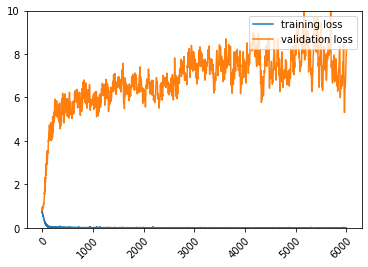

Epoch: 0000 loss_train: 0.9205 loss_val: 0.8659
Epoch: 0050 loss_train: 0.2139 loss_val: 0.9096
Epoch: 0100 loss_train: 0.0566 loss_val: 1.7751
Epoch: 0150 loss_train: 0.0421 loss_val: 2.1220
Epoch: 0200 loss_train: 0.0153 loss_val: 2.3045
Epoch: 0250 loss_train: 0.0151 loss_val: 2.4111
Epoch: 0300 loss_train: 0.0189 loss_val: 2.6415
Epoch: 0350 loss_train: 0.0282 loss_val: 2.5251
Epoch: 0400 loss_train: 0.0099 loss_val: 2.8632
Epoch: 0450 loss_train: 0.0182 loss_val: 3.0121
Epoch: 0500 loss_train: 0.0118 loss_val: 2.5405
Epoch: 0550 loss_train: 0.0125 loss_val: 3.0100
Epoch: 0600 loss_train: 0.0171 loss_val: 2.8329
Epoch: 0650 loss_train: 0.0110 loss_val: 3.3174
Epoch: 0700 loss_train: 0.0051 loss_val: 3.2495
Epoch: 0750 loss_train: 0.0141 loss_val: 2.9566
Epoch: 0800 loss_train: 0.0097 loss_val: 3.4276
Epoch: 0850 loss_train: 0.0137 loss_val: 3.0376
Epoch: 0900 loss_train: 0.0126 loss_val: 2.9897
Epoch: 0950 loss_train: 0.0085 loss_val: 2.8860
Epoch: 1000 loss_train: 0.0080 loss_val:

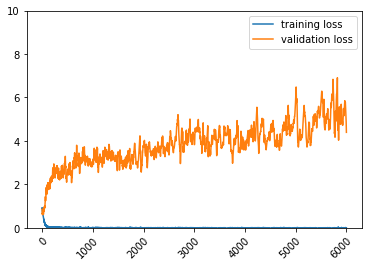

Epoch: 0000 loss_train: 1.1191 loss_val: 1.2109
Epoch: 0050 loss_train: 0.4130 loss_val: 1.7496
Epoch: 0100 loss_train: 0.1574 loss_val: 2.7918
Epoch: 0150 loss_train: 0.0704 loss_val: 3.5300
Epoch: 0200 loss_train: 0.0633 loss_val: 4.4977
Epoch: 0250 loss_train: 0.0396 loss_val: 4.7908
Epoch: 0300 loss_train: 0.0222 loss_val: 4.7745
Epoch: 0350 loss_train: 0.0232 loss_val: 4.3673
Epoch: 0400 loss_train: 0.0268 loss_val: 4.6185
Epoch: 0450 loss_train: 0.0228 loss_val: 4.5786
Epoch: 0500 loss_train: 0.0157 loss_val: 5.2336
Epoch: 0550 loss_train: 0.0565 loss_val: 4.8907
Epoch: 0600 loss_train: 0.0408 loss_val: 4.9482
Epoch: 0650 loss_train: 0.0212 loss_val: 5.1382
Epoch: 0700 loss_train: 0.0145 loss_val: 5.5445
Epoch: 0750 loss_train: 0.0113 loss_val: 5.2011
Epoch: 0800 loss_train: 0.0134 loss_val: 5.4523
Epoch: 0850 loss_train: 0.0134 loss_val: 5.3509
Epoch: 0900 loss_train: 0.0181 loss_val: 4.9201
Epoch: 0950 loss_train: 0.0136 loss_val: 4.8558
Epoch: 1000 loss_train: 0.0345 loss_val:

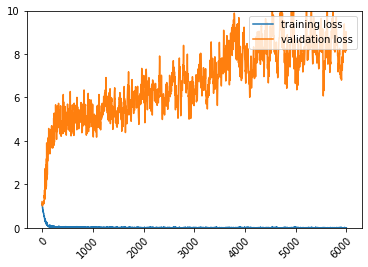

Epoch: 0000 loss_train: 0.9908 loss_val: 0.9776
Epoch: 0050 loss_train: 0.5169 loss_val: 0.7991
Epoch: 0100 loss_train: 0.2085 loss_val: 1.5531
Epoch: 0150 loss_train: 0.0989 loss_val: 1.9911
Epoch: 0200 loss_train: 0.0507 loss_val: 2.5618
Epoch: 0250 loss_train: 0.0398 loss_val: 2.5646
Epoch: 0300 loss_train: 0.0323 loss_val: 2.4062
Epoch: 0350 loss_train: 0.0361 loss_val: 3.2118
Epoch: 0400 loss_train: 0.0196 loss_val: 3.1590
Epoch: 0450 loss_train: 0.0190 loss_val: 2.7806
Epoch: 0500 loss_train: 0.0232 loss_val: 3.0636
Epoch: 0550 loss_train: 0.0162 loss_val: 2.8756
Epoch: 0600 loss_train: 0.0222 loss_val: 3.1793
Epoch: 0650 loss_train: 0.0253 loss_val: 2.9189
Epoch: 0700 loss_train: 0.0324 loss_val: 2.5219
Epoch: 0750 loss_train: 0.0145 loss_val: 3.3546
Epoch: 0800 loss_train: 0.0103 loss_val: 3.0485
Epoch: 0850 loss_train: 0.0099 loss_val: 3.0653
Epoch: 0900 loss_train: 0.0283 loss_val: 3.1675
Epoch: 0950 loss_train: 0.0177 loss_val: 2.9031
Epoch: 1000 loss_train: 0.0133 loss_val:

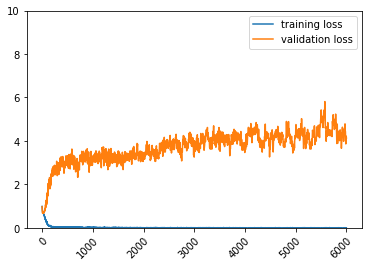

Epoch: 0000 loss_train: 1.0612 loss_val: 1.1079
Epoch: 0050 loss_train: 0.2984 loss_val: 2.7715
Epoch: 0100 loss_train: 0.0921 loss_val: 5.5308
Epoch: 0150 loss_train: 0.0395 loss_val: 6.6324
Epoch: 0200 loss_train: 0.0176 loss_val: 7.0083
Epoch: 0250 loss_train: 0.0422 loss_val: 7.9943
Epoch: 0300 loss_train: 0.0352 loss_val: 8.1028
Epoch: 0350 loss_train: 0.0081 loss_val: 6.6315
Epoch: 0400 loss_train: 0.0167 loss_val: 8.2340
Epoch: 0450 loss_train: 0.0464 loss_val: 8.8941
Epoch: 0500 loss_train: 0.0415 loss_val: 8.6251
Epoch: 0550 loss_train: 0.0202 loss_val: 7.9214
Epoch: 0600 loss_train: 0.0043 loss_val: 8.6890
Epoch: 0650 loss_train: 0.0123 loss_val: 8.7001
Epoch: 0700 loss_train: 0.0041 loss_val: 8.9960
Epoch: 0750 loss_train: 0.0072 loss_val: 7.8615
Epoch: 0800 loss_train: 0.0049 loss_val: 8.2349
Epoch: 0850 loss_train: 0.0139 loss_val: 8.7759
Epoch: 0900 loss_train: 0.0032 loss_val: 8.7148
Epoch: 0950 loss_train: 0.0086 loss_val: 9.3929
Epoch: 1000 loss_train: 0.0369 loss_val:

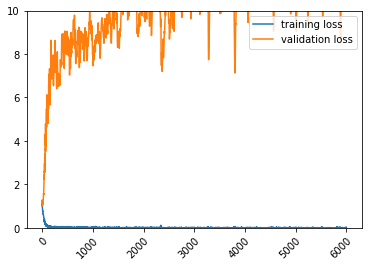

Epoch: 0000 loss_train: 1.0110 loss_val: 1.2712
Epoch: 0050 loss_train: 0.2559 loss_val: 2.5332
Epoch: 0100 loss_train: 0.0523 loss_val: 4.6471
Epoch: 0150 loss_train: 0.0372 loss_val: 5.7537
Epoch: 0200 loss_train: 0.0351 loss_val: 5.5684
Epoch: 0250 loss_train: 0.0151 loss_val: 5.9943
Epoch: 0300 loss_train: 0.0228 loss_val: 5.7349
Epoch: 0350 loss_train: 0.0237 loss_val: 5.9323
Epoch: 0400 loss_train: 0.0162 loss_val: 7.3159
Epoch: 0450 loss_train: 0.0066 loss_val: 6.6698
Epoch: 0500 loss_train: 0.0195 loss_val: 7.0488
Epoch: 0550 loss_train: 0.0092 loss_val: 6.0033
Epoch: 0600 loss_train: 0.0038 loss_val: 6.9019
Epoch: 0650 loss_train: 0.0220 loss_val: 7.9169
Epoch: 0700 loss_train: 0.0064 loss_val: 6.7333
Epoch: 0750 loss_train: 0.0123 loss_val: 8.0444
Epoch: 0800 loss_train: 0.0180 loss_val: 7.4907
Epoch: 0850 loss_train: 0.0077 loss_val: 8.4369
Epoch: 0900 loss_train: 0.0223 loss_val: 7.5377
Epoch: 0950 loss_train: 0.0115 loss_val: 7.2457
Epoch: 1000 loss_train: 0.0350 loss_val:

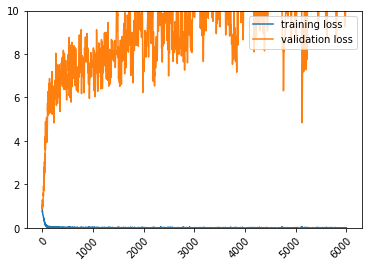

Epoch: 0000 loss_train: 1.0613 loss_val: 1.0805
Epoch: 0050 loss_train: 0.4339 loss_val: 1.8031
Epoch: 0100 loss_train: 0.1321 loss_val: 3.1672
Epoch: 0150 loss_train: 0.0628 loss_val: 4.8791
Epoch: 0200 loss_train: 0.0478 loss_val: 5.8996
Epoch: 0250 loss_train: 0.0379 loss_val: 6.5342
Epoch: 0300 loss_train: 0.0418 loss_val: 6.3204
Epoch: 0350 loss_train: 0.0256 loss_val: 5.9170
Epoch: 0400 loss_train: 0.0352 loss_val: 6.6039
Epoch: 0450 loss_train: 0.0203 loss_val: 6.3282
Epoch: 0500 loss_train: 0.0262 loss_val: 6.8869
Epoch: 0550 loss_train: 0.0170 loss_val: 7.4554
Epoch: 0600 loss_train: 0.0308 loss_val: 6.6251
Epoch: 0650 loss_train: 0.0127 loss_val: 6.3323
Epoch: 0700 loss_train: 0.0123 loss_val: 7.8847
Epoch: 0750 loss_train: 0.0270 loss_val: 6.5996
Epoch: 0800 loss_train: 0.0105 loss_val: 7.0276
Epoch: 0850 loss_train: 0.0139 loss_val: 7.9103
Epoch: 0900 loss_train: 0.0088 loss_val: 8.7455
Epoch: 0950 loss_train: 0.0098 loss_val: 7.4889
Epoch: 1000 loss_train: 0.0136 loss_val:

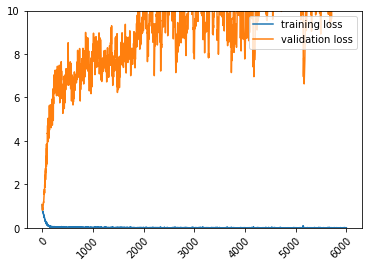

Epoch: 0000 loss_train: 0.9471 loss_val: 1.0339
Epoch: 0050 loss_train: 0.2870 loss_val: 2.1641
Epoch: 0100 loss_train: 0.0567 loss_val: 4.1581
Epoch: 0150 loss_train: 0.0438 loss_val: 4.6611
Epoch: 0200 loss_train: 0.0305 loss_val: 5.4998
Epoch: 0250 loss_train: 0.0145 loss_val: 6.6518
Epoch: 0300 loss_train: 0.0157 loss_val: 5.4039
Epoch: 0350 loss_train: 0.0349 loss_val: 5.3567
Epoch: 0400 loss_train: 0.0106 loss_val: 5.3996
Epoch: 0450 loss_train: 0.0160 loss_val: 5.2503
Epoch: 0500 loss_train: 0.0141 loss_val: 5.5528
Epoch: 0550 loss_train: 0.0103 loss_val: 5.7188
Epoch: 0600 loss_train: 0.0076 loss_val: 5.4052
Epoch: 0650 loss_train: 0.0041 loss_val: 5.0300
Epoch: 0700 loss_train: 0.0076 loss_val: 5.6109
Epoch: 0750 loss_train: 0.0074 loss_val: 5.8644
Epoch: 0800 loss_train: 0.0091 loss_val: 4.8102
Epoch: 0850 loss_train: 0.0057 loss_val: 4.6098
Epoch: 0900 loss_train: 0.0058 loss_val: 5.1414
Epoch: 0950 loss_train: 0.0046 loss_val: 5.0801
Epoch: 1000 loss_train: 0.0126 loss_val:

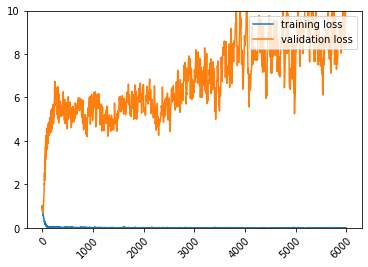

Epoch: 0000 loss_train: 0.9019 loss_val: 1.0734
Epoch: 0050 loss_train: 0.2621 loss_val: 2.0025
Epoch: 0100 loss_train: 0.0780 loss_val: 3.6049
Epoch: 0150 loss_train: 0.0173 loss_val: 5.0870
Epoch: 0200 loss_train: 0.0292 loss_val: 5.4803
Epoch: 0250 loss_train: 0.0294 loss_val: 5.6516
Epoch: 0300 loss_train: 0.0115 loss_val: 5.6156
Epoch: 0350 loss_train: 0.0118 loss_val: 5.9500
Epoch: 0400 loss_train: 0.0117 loss_val: 5.8208
Epoch: 0450 loss_train: 0.0169 loss_val: 7.2475
Epoch: 0500 loss_train: 0.0105 loss_val: 7.0961
Epoch: 0550 loss_train: 0.0136 loss_val: 5.7336
Epoch: 0600 loss_train: 0.0038 loss_val: 7.1597
Epoch: 0650 loss_train: 0.0088 loss_val: 6.5434
Epoch: 0700 loss_train: 0.0085 loss_val: 7.2924
Epoch: 0750 loss_train: 0.0171 loss_val: 6.8255
Epoch: 0800 loss_train: 0.0061 loss_val: 7.4786
Epoch: 0850 loss_train: 0.0022 loss_val: 7.4607
Epoch: 0900 loss_train: 0.0174 loss_val: 7.8218
Epoch: 0950 loss_train: 0.0075 loss_val: 7.7659
Epoch: 1000 loss_train: 0.0160 loss_val:

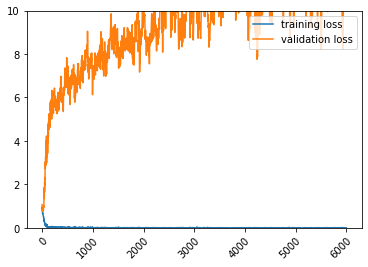

Epoch: 0000 loss_train: 0.7968 loss_val: 0.7896
Epoch: 0050 loss_train: 0.3577 loss_val: 1.0130
Epoch: 0100 loss_train: 0.1263 loss_val: 2.2064
Epoch: 0150 loss_train: 0.0410 loss_val: 2.5267
Epoch: 0200 loss_train: 0.0570 loss_val: 3.1489
Epoch: 0250 loss_train: 0.0812 loss_val: 3.3263
Epoch: 0300 loss_train: 0.0290 loss_val: 3.0569
Epoch: 0350 loss_train: 0.0464 loss_val: 2.9290
Epoch: 0400 loss_train: 0.0298 loss_val: 3.3542
Epoch: 0450 loss_train: 0.0251 loss_val: 3.8891
Epoch: 0500 loss_train: 0.0250 loss_val: 3.8583
Epoch: 0550 loss_train: 0.0179 loss_val: 3.0341
Epoch: 0600 loss_train: 0.0103 loss_val: 3.1469
Epoch: 0650 loss_train: 0.0181 loss_val: 3.5303
Epoch: 0700 loss_train: 0.0356 loss_val: 3.0766
Epoch: 0750 loss_train: 0.0198 loss_val: 3.1901
Epoch: 0800 loss_train: 0.0149 loss_val: 2.9810
Epoch: 0850 loss_train: 0.0172 loss_val: 3.3316
Epoch: 0900 loss_train: 0.0162 loss_val: 3.3938
Epoch: 0950 loss_train: 0.0337 loss_val: 3.5008
Epoch: 1000 loss_train: 0.0063 loss_val:

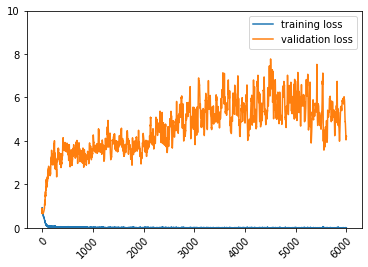

Epoch: 0000 loss_train: 0.6619 loss_val: 0.6422
Epoch: 0050 loss_train: 0.2745 loss_val: 0.8432
Epoch: 0100 loss_train: 0.1322 loss_val: 1.9216
Epoch: 0150 loss_train: 0.0444 loss_val: 2.5447
Epoch: 0200 loss_train: 0.0294 loss_val: 2.4349
Epoch: 0250 loss_train: 0.0128 loss_val: 2.7666
Epoch: 0300 loss_train: 0.0130 loss_val: 2.7724
Epoch: 0350 loss_train: 0.0111 loss_val: 2.8871
Epoch: 0400 loss_train: 0.0291 loss_val: 3.3924
Epoch: 0450 loss_train: 0.0137 loss_val: 3.2780
Epoch: 0500 loss_train: 0.0089 loss_val: 3.3688
Epoch: 0550 loss_train: 0.0084 loss_val: 3.4372
Epoch: 0600 loss_train: 0.0120 loss_val: 3.5546
Epoch: 0650 loss_train: 0.0077 loss_val: 3.2881
Epoch: 0700 loss_train: 0.0065 loss_val: 3.2858
Epoch: 0750 loss_train: 0.0052 loss_val: 3.3278
Epoch: 0800 loss_train: 0.0076 loss_val: 3.6665
Epoch: 0850 loss_train: 0.0065 loss_val: 3.4215
Epoch: 0900 loss_train: 0.0117 loss_val: 3.4639
Epoch: 0950 loss_train: 0.0060 loss_val: 3.3385
Epoch: 1000 loss_train: 0.0035 loss_val:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
pctVal=0.05
pctTest=0.1

for i in np.unique(clusterRes):
    logsavepath_i=os.path.join(logsavepath,str(i))
    plotsavepath_i=os.path.join(plotsavepath,str(i))
    modelsavepath_i=os.path.join(modelsavepath,str(i))
    if not os.path.exists(logsavepath_i):
        os.mkdir(logsavepath_i)
    if not os.path.exists(modelsavepath_i):
        os.mkdir(modelsavepath_i)
    if not os.path.exists(plotsavepath_i):
        os.mkdir(plotsavepath_i)
        
    for i_sub in np.unique(alllabels_sub[alllabels==i]):
        logsavepath_sub=os.path.join(logsavepath_i,str(i_sub))
        plotsavepath_sub=os.path.join(plotsavepath_i,str(i_sub))
        modelsavepath_sub=os.path.join(modelsavepath_i,str(i_sub))
        if not os.path.exists(logsavepath_sub):
            os.mkdir(logsavepath_sub)
        if not os.path.exists(modelsavepath_sub):
            os.mkdir(modelsavepath_sub)
        if not os.path.exists(plotsavepath_sub):
            os.mkdir(plotsavepath_sub)
        

#         stats_sub=allstats[alllabels==i]
#         labels_sub=alllabels_sub[alllabels==i]
        stats_sub=alllatents[np.logical_and(alllabels==i,alllabels_sub==i_sub)]
        labels_sub=allstats[np.logical_and(alllabels==i,alllabels_sub==i_sub)]

        #train-test split
        np.random.seed(3)
        allIdx=np.arange(stats_sub.shape[0])
        np.random.shuffle(allIdx)
        valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
        testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
        trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]

        trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
        fig, ax = plt.subplots()
        plt.bar(trainLabels,traincounts)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        plt.savefig(os.path.join(plotsavepath_sub,'labelCounts.jpg'))

        posweight=torch.tensor([np.sum(labels_sub[trainIdx]==0)/np.sum(labels_sub[trainIdx]==1)]).cuda().float()

        # Create model
        seed=3
        torch.manual_seed(seed)
        nclasses=1
        if use_cuda:
            torch.cuda.manual_seed(seed)

        if model_str=='fc3':
            model = modelsCNN.FC_l3(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc5':
            model = modelsCNN.FC_l5(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc1':
            model = modelsCNN.FC_l1(stats_sub.shape[1],fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc0':
            model = modelsCNN.FC_l0(stats_sub.shape[1],nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)

        if use_cuda:
            model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss_ep=[None]*epochs
        val_loss_ep=[None]*epochs
        t_ep=time.time()

        for ep in range(epochs):
        # for ep in range(10000,20000):

            train_loss_ep[ep],val_loss_ep[ep]=train(ep)


            if ep%saveFreq == 0 and ep!=0:
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_sub,str(ep)+'.pt'))
            if use_cuda:
                model.cuda()
                torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))
        with open(os.path.join(logsavepath_sub,'train_loss'), 'wb') as output:
            pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_sub,'val_loss'), 'wb') as output:
            pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)

        plt.plot(np.arange(epochs),train_loss_ep)
        plt.plot(np.arange(epochs),val_loss_ep)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.ylim(0,10)
        plt.savefig(os.path.join(plotsavepath_sub,'loss_seed3.jpg'))
        plt.show()



In [13]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(np.unique(ctlist).size))
    ax.set_xticklabels(np.unique(ctlist))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [38]:
torch.nn.functional.sigmoid(pred)

/usr/lib/python3/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[4.6589e-18],
        [1.0000e+00],
        [0.0000e+00],
        ...,
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00]], device='cuda:0')

In [14]:
#test loss
ep=5800

for c in np.unique(clusterRes):
    print(c)
    logsavepath_i=os.path.join(logsavepath,str(c))
    plotsavepath_i=os.path.join(plotsavepath,str(c))
    modelsavepath_i=os.path.join(modelsavepath,str(c))
    if not os.path.exists(logsavepath_i):
        os.mkdir(logsavepath_i)
    if not os.path.exists(modelsavepath_i):
        os.mkdir(modelsavepath_i)
    if not os.path.exists(plotsavepath_i):
        os.mkdir(plotsavepath_i)
        
    for i_sub in np.unique(alllabels_sub[alllabels==c]):
        print(i_sub)
        logsavepath_sub=os.path.join(logsavepath_i,str(i_sub))
        plotsavepath_sub=os.path.join(plotsavepath_i,str(i_sub))
        modelsavepath_sub=os.path.join(modelsavepath_i,str(i_sub))
        if not os.path.exists(logsavepath_sub):
            os.mkdir(logsavepath_sub)
        if not os.path.exists(modelsavepath_sub):
            os.mkdir(modelsavepath_sub)
        if not os.path.exists(plotsavepath_sub):
            os.mkdir(plotsavepath_sub)
        

#         stats_sub=allstats[alllabels==i]
#         labels_sub=alllabels_sub[alllabels==i]
        stats_sub=alllatents[np.logical_and(alllabels==c,alllabels_sub==i_sub)]
        labels_sub=allstats[np.logical_and(alllabels==c,alllabels_sub==i_sub)]

    
        #train-test split
        np.random.seed(3)
        allIdx=np.arange(stats_sub.shape[0])
        np.random.shuffle(allIdx)
        valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
        testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
        trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]

        trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
        posweight=torch.tensor([np.sum(labels_sub[trainIdx]==0)/np.sum(labels_sub[trainIdx]==1)]).cuda().float()

        # Create model
        seed=3
        torch.manual_seed(seed)
        nclasses=1
        if use_cuda:
            torch.cuda.manual_seed(seed)

        if model_str=='fc3':
            model = modelsCNN.FC_l3(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc5':
            model = modelsCNN.FC_l5(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc1':
            model = modelsCNN.FC_l1(stats_sub.shape[1],fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc0':
            model = modelsCNN.FC_l0(stats_sub.shape[1],nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)

        if use_cuda:
            model.cuda()

        model.load_state_dict(torch.load(os.path.join(modelsavepath_sub,str(ep)+'.pt')))
        predtest=np.array([])
        with torch.no_grad():
            model.cuda()
            model.eval()
            loss_test_all=0
            ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
            for i in range(ntestBatches):
                testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
                testInput=torch.tensor(stats_sub[testIdx_i])
                if use_cuda:
                    testInput=testInput.cuda().float()
                    labels=torch.tensor(labels_sub[testIdx_i]).cuda().float()
                pred = model(testInput)
                predtest=np.concatenate((predtest,(torch.nn.functional.sigmoid(pred.cpu().detach()).numpy().flatten())>0.5))

                loss_test=lossCE(pred.flatten(),labels).item()

                loss_test_all+=loss_test

            loss_test_all=loss_test_all/ntestBatches

        print('test loss: '+str(loss_test_all))

        plotCTcomp(labels_sub[testIdx],predtest,plotsavepath_sub,'confusion_test',False)

        predtrain=np.array([])
        with torch.no_grad():
            model.cuda()
            model.eval()
            loss_train_all=0
            ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
            for i in range(ntrainBatches):
                trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
                trainInput=torch.tensor(stats_sub[trainIdx_i])
                if use_cuda:
                    trainInput=trainInput.cuda().float()
                    labels=torch.tensor(labels_sub[trainIdx_i]).cuda().float()
                pred = model(trainInput)
                predtrain=np.concatenate((predtrain,(torch.nn.functional.sigmoid(pred.cpu().detach()).numpy().flatten())>0.5))

                loss_train=lossCE(pred.flatten(),labels).item()

                loss_train_all+=loss_train

            loss_train_all=loss_train_all/ntrainBatches

        print('train loss: '+str(loss_train_all))
        plotCTcomp(labels_sub[trainIdx],predtrain,plotsavepath_sub,'confusion_train',False)

0
0.0
test loss: 3.3264002799987793
train loss: 3.6199289752403274e-06


/usr/lib/python3/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1.0
test loss: 10.538576126098633
train loss: 1.4887017641740385e-05
2.0
test loss: 4.4801201820373535
train loss: 9.42641418077983e-06
3.0
test loss: 3.4749913215637207
train loss: 1.0782317758639692e-06
1
0.0
test loss: 8.4337739944458
train loss: 9.284374755225144e-06
1.0
test loss: 11.464437484741211
train loss: 8.836072811391205e-05
2.0
test loss: 12.560795783996582
train loss: 3.136976374662481e-05
3.0
test loss: 9.31008243560791
train loss: 5.088870966574177e-05
4.0
test loss: 9.958229064941406
train loss: 7.989352525328286e-06
5.0
test loss: 6.5878801345825195
train loss: 5.8085747696168255e-06
2
0.0
test loss: 3.757838249206543
train loss: 7.70407837080711e-07
1.0
test loss: 16.879026412963867
train loss: 1.1057982618467577e-07
2.0
test loss: 5.833687782287598
train loss: 1.298811156402735e-07
3.0
test loss: 5.137086391448975
train loss: 6.601868562938762e-07
4.0
test loss: 4.121954441070557
train loss: 5.570536814047955e-07
5.0
test loss: 7.0389604568481445
train loss: 6.0893

In [41]:
np.sum(np.logical_and(alllabels==i,alllabels_sub==i_sub))

0

In [42]:
i

0

In [43]:
i_sub

4.0

In [44]:
np.unique(alllabels_sub[alllabels==i])

array([0., 1., 2., 3.])